# Test Trotterization on FakeJakarta with Shallow Circuits

- Status: OK

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_69630/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("../utils/")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [7]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps = 100
print("trotter step: ", num_steps)

scale_factors = [1.0, 2.0, 3.0]

trotter step:  100


# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

In [8]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(num_qubits, name="q")
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
subspace_decoder_init110(qc, targets=[0, 1, 2]) # decode

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time / num_steps})
print("created qc")

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
print("created st_qcs (length:", len(st_qcs), ")")

# remove barriers
st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
print("removed barriers from st_qcs")

# optimize circuit
t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

# zne wrapping
zne_qcs = t3_st_qcs
# zne_qcs = zne_wrapper(t3_st_qcs, scale_factors = scale_factors, pt = False)
# print("created zne_qcs (length:", len(zne_qcs), ")")

# optimization_level must be 0
# feed initial_layout here to see the picture of the circuits before casting the job
t3_zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
print("created t3_zne_qcs (length:", len(t3_zne_qcs), ")")

created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )


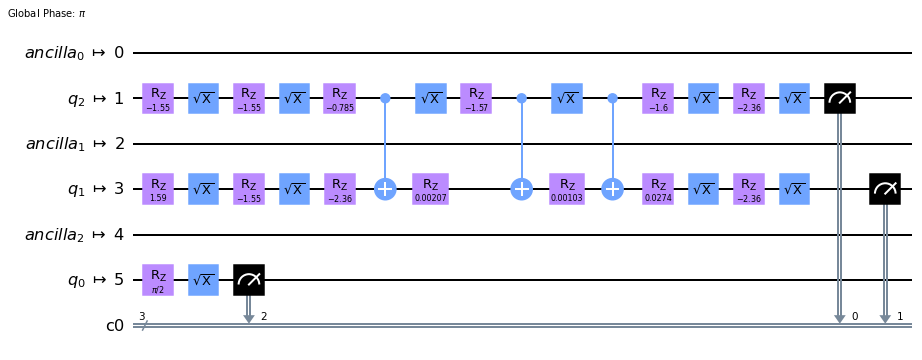

In [9]:
t3_zne_qcs[-3].draw("mpl")

# Set Backend

In [10]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# print("provider:", provider)
# backend = provider.get_backend("ibmq_jakarta")
print(str(backend))

fake_jakarta


# Execute Circuits

In [11]:
shots = 1 << 13
reps = 8 # unused
jobs = []
for _ in range(reps):
    #! CHECK: run t3_zne_qcs, with optimization_level = 0 and straightforward initial_layout
    job = execute(t3_zne_qcs, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID d77b85a7-c7cc-4237-80c7-faa4b0190b5a
Job ID 8370bb37-15f1-4721-9418-98a593cea352
Job ID 08a43e7c-47dc-49a3-8cf0-d1c2f397a87a
Job ID 0f6f436d-b70a-4cbb-beb2-63176c0e9c67
Job ID f81f40d4-a0a8-440a-92a4-5a0fa0323492
Job ID 6dabf43a-cb5e-48a5-ba83-7552f27e8970
Job ID a3665819-b2f2-48dc-9183-e48c35ba3e5f
Job ID a1e10f14-ca25-4e83-8c16-dd50b924943c


# QREM

Job ID 971ea387-4315-4cbe-aebf-407062a57d08


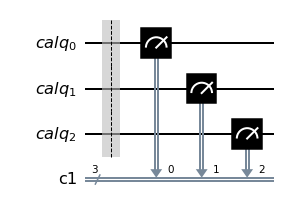

In [12]:
# QREM
qr = QuantumRegister(num_qubits, name="calq")
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# we have to feed initial_layout to calibration matrix
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())
meas_calibs[0].draw("mpl")

In [13]:
dt_now = datetime.datetime.now()
print(dt_now)

2022-04-17 21:18:00.024073


In [14]:
filename = "job_ids_" + str(backend) + "_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl"
print(filename)

job_ids_fake_jakarta_100step_20220417_211800_.pkl


In [15]:
# with open("jobs_" + str(backend) + "_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
#     pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)

In [16]:
# with open(filename, "wb") as f:
#     pickle.dump({"job_ids": [job.job_id() for job in jobs], "cal_job_id": cal_job.job_id()}, f)

In [17]:
# with open("properties_" + str(backend) + "_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
#     pickle.dump(backend.properties(), f)

# ============ wait for results ============

In [18]:
retrieved_jobs = jobs
retrieved_cal_job = cal_job

In [19]:
cal_results = retrieved_cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# State Tomography

In [20]:
target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

In [21]:
fids = []
for job in retrieved_jobs:
    # mit_results = meas_fitter.filter.apply(job.result())
    rho = StateTomographyFitter(job.result(), t3_zne_qcs).fit(method='lstsq')
    fid = state_fidelity(rho, target_state)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.8863 ± 0.0012
